In [1]:
import pandas as pd
import geopandas as gpd
from pyproj.transformer import Transformer
from shapely.geometry import asLineString
import numpy as np
import shapely
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union, LineString
from sklearn.cluster import DBSCAN
import math
import statistics

import pptk

In [2]:
lidarData = pd.read_csv("HD_Run1(0).csv")
lidarGDF = gpd.GeoDataFrame(data=lidarData, crs=4326, geometry=gpd.points_from_xy(lidarData["X"], lidarData["Y"]))

In [3]:
gpsData = pd.read_csv("gps.csv")
gpsGDF = gpd.GeoDataFrame(data=gpsData,crs=4326, geometry=gpd.points_from_xy(gpsData["X"], gpsData["Y"]) )

In [4]:
gpsNP = gpsGDF.filter(['X','Y'])
#gpsNP = gpsData.to_numpy()
gpsNP = gpsNP.to_numpy()
gpsNP
# projectionTrans = Transformer.from_crs(4326, 'ESRI:102604', always_xy=True)
# projPoints = np.array(projectionTrans.transform(point_list[:,0], point_list[:, 1], direction="forward")).T
# projPoints

array([[ 741948.13574186, 3740375.0480521 ],
       [ 741944.71207241, 3740377.01450509],
       [ 741941.73457311, 3740380.94014779],
       ...,
       [ 741167.32155059, 3739963.45671755],
       [ 741172.26983538, 3739963.76607482],
       [ 741177.21351268, 3739963.89107656]])

/Users/elu/opt/anaconda3/envs/pptk_test/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: ShapelyDeprecationWarning: The proxy geometries (through the 'asShape()', 'asLineString()' or 'LineStringAdapter()' constructors) are deprecated and will be removed in Shapely 2.0. Use the 'shape()' function or the standard 'LineString()' constructor instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


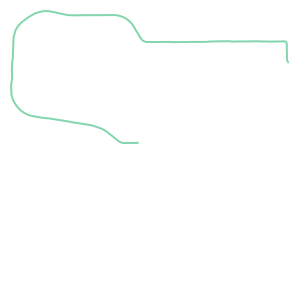

In [5]:
GPSline = asLineString(gpsNP)
GPSline

In [6]:
# Creates a 5m buffer around the GPS tragetory, and a list of all the LiDAR points within that buffer

pointsWithinBuffer = lidarGDF.sindex.query(GPSline.buffer(5), predicate="contains")
print(pointsWithinBuffer.shape)

pointsWithinBuffer = np.asarray(pointsWithinBuffer)
offsetFilteredDf = lidarData.loc[pointsWithinBuffer]

(6820867,)


In [7]:
# Elevation Filtering

for pt in gpsNP:
    sampleBuffer = Point(pt[0], pt[1]).buffer(0.5)
    pointsWithinBuffer = lidarGDF.sindex.query(sampleBuffer, predicate="contains")

    if len(pointsWithinBuffer) > 0:
        median_elevation = statistics.median(lidarData.loc[np.asarray(pointsWithinBuffer)]['Z'])
        offsetFilteredDf = offsetFilteredDf[(offsetFilteredDf['X'] > pt[0] + 5) | (offsetFilteredDf['X'] < pt[0] - 5)  | (offsetFilteredDf['Y'] > pt[1] + 5) | (offsetFilteredDf['Y'] < pt[1] - 5) | (offsetFilteredDf['Z'] < median_elevation + 0.6)]

        
print(offsetFilteredDf.shape)
    

(6584740, 9)


251


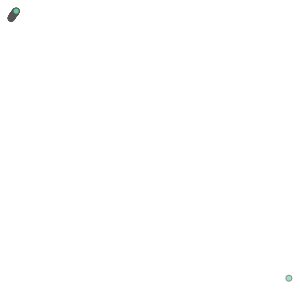

In [8]:
## PARTITION GPS LINE

slice_frequency = 0.08
slice_depth = 0.1
whole_line = False

# Chose a range on the line. 2000-2200 works well
range_start = 1570
range_end = 1590
sample_starts = np.arange(range_start, range_end, slice_frequency)

if whole_line:
    sample_starts = np.arange(0, GPSline.length, slice_frequency)

start_points = [GPSline.interpolate(distance) for distance in sample_starts] + [GPSline.boundary.geoms[1]]
start_points = unary_union(start_points)
print(len(start_points.geoms))
start_points

In [9]:
## CREATE SLICES OF ROAD, BASED ON DIST

slices = []

for dist in sample_starts:
#for g in range(0, 150):
    #dist = sample_starts[g]

    sample_start = GPSline.interpolate(dist)
    sample_end = GPSline.interpolate(dist + slice_depth)
    sample_buffer = LineString([sample_start, sample_end]).buffer(5, cap_style=2)
    offset_line = LineString([sample_buffer.exterior.coords[3], sample_buffer.exterior.coords[4]])
    
    sample_df = lidarData.loc[np.asarray(lidarGDF.sindex.query(sample_buffer, predicate="contains"))]
    points_in_sample = []
    for i in sample_df['Id']:
        points_in_sample.append((i, sample_df.loc[i]['geometry']))
    

    points_in_sample = sorted(points_in_sample, key=lambda x: x[1].distance(offset_line))

    slice = []
    for pt in points_in_sample:
        slice.append((pt[1].distance(offset_line), sample_df.loc[pt[0]]['Z'], sample_df.loc[pt[0]]['geometry']))
    slices.append((dist, slice))

    # Each "slice" in slices is a tuple of (dist_from_offset, z, POINT())
    # Slices are sorted by their distance from the offset line

    
    

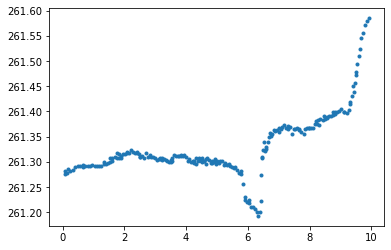

In [10]:
profile_x = []
profile_y = []

for pt in slices[(len(slices) // 2)][1]:
    profile_x.append(pt[0])
    profile_y.append(pt[1])

plt.scatter(profile_x, profile_y, marker='.', alpha=1)
plt.show()

In [11]:
## EDGE CREATION BASED ON DERIVATIVE

edges = []
h = 5
mg = 1.02 # minimum gradient
ma = 0.05 # minimum acceleration
mstd = 0.5 # minimum std_dev derivative

for dist_and_slice in slices:
    values = []
    std_devs = []
    dist = dist_and_slice[0]
    slice = dist_and_slice[1]
    count = 0
    for i in range((len(slice) - (len(slice) % h)) // 2, len(slice) - (len(slice) % h), h):
        pt = (statistics.mean([x[0] for x in slice[i:i+h]]), statistics.mean([x[1] for x in slice[i:i+h]]))
        deviation = statistics.stdev([x[1] for x in slice[i:i+h]])
        ## Check last and sign, add if sign changes
        if len(values) < 5:
            values.append(pt[1])
            std_devs.append(deviation)
        else:
            values = values[1:]
            values.append(pt[1])
            std_devs = std_devs[1:]
            std_devs.append(deviation)
            if (values[0] > values[1]+mg and values[1] > values[2]+mg and values[3] > values[2]+mg and values[4] > values[3]+mg):
                edges.append((dist, Point(slice[i][2].x, slice[i][2].y, slice[i][1]), slice[i][0]))
            elif (values[0]+mg < values[1] and values[1]+mg < values[2] and values[3]+mg < values[2] and values[4]+mg < values[3]):
                edges.append((dist, Point(slice[i][2].x, slice[i][2].y, slice[i][1]), slice[i][0]))
            elif abs((values[4] - values[3]) - (values[3] - values[2])) > ma:
                edges.append((dist, Point(slice[i][2].x, slice[i][2].y, slice[i][1]), slice[i][0]))
            elif (abs(std_devs[4] - std_devs[3]) > mstd):
                edges.append((dist, Point(slice[i][2].x, slice[i][2].y, slice[i][1]), slice[i][0]))
        count += 1

print(len(edges))

631


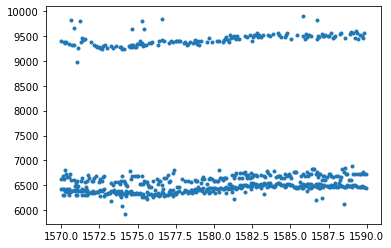

631


In [12]:
edge_plot_x = []
edge_plot_y = []
for pt in edges:
    if pt[2]:
        edge_plot_x.append(pt[0])
        edge_plot_y.append(1000 * pt[2])

plt.scatter(edge_plot_x, edge_plot_y, marker='.', alpha=1)
plt.show()

print(len(edge_plot_x))

631


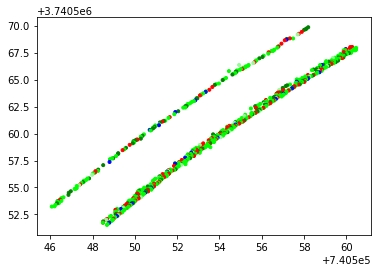

array([ 0,  1,  2,  0,  0,  1,  0,  0,  1,  2,  0, -1,  2,  0,  3,  2,  0,
        0,  1,  0,  0,  1,  4,  0,  3,  0,  1, -1,  0,  4,  0,  1,  4, -1,
        0,  0,  0,  0,  0,  0,  0,  5, -1,  0,  0,  6,  0, -1,  0,  5,  2,
        0,  0,  1,  7,  0,  2,  0,  0,  0,  7,  0,  0,  0,  0,  5,  0,  1,
        0,  1,  0,  2,  0,  5,  0,  5,  0,  1,  4,  0,  1,  4,  0,  4,  0,
        0,  5,  4,  0,  0,  1,  6,  0,  5,  6,  0,  1,  4,  0,  0,  1,  0,
        4,  0,  6,  0,  0,  0, -1,  0,  0,  4,  0, -1,  4,  0,  0,  0,  0,
        0,  4,  0,  5,  0,  0,  0,  4,  8,  0,  5,  4, -1,  0,  1,  6,  0,
        5,  6, -1,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0, -1,  4,  0,  0,
        1,  4,  0,  1,  4,  9,  0,  4,  0,  1,  4,  0,  4,  0,  1,  4,  0,
        1,  4,  0,  0,  2,  0,  0,  4,  8,  1,  2, -1,  0,  0,  4,  8,  5,
        4,  9,  8,  5,  4, 10,  0,  5,  0,  0,  0,  0,  2,  0,  0,  2,  0,
        2,  8,  5,  0,  0,  0,  0,  1,  0,  0,  4,  0,  5,  2,  0,  5,  0,
        0,  2, -1,  0,  0

In [13]:
dbscan_eplsilon = 9
dbscan_min_samples = 2

X = np.vstack((np.array(edge_plot_x), np.array(edge_plot_y))).T
clustering = DBSCAN(eps=dbscan_eplsilon, min_samples=dbscan_min_samples).fit(X)


color_labels = ["lime", "r", "g", "b", "m", "c", "y", "k", "blueviolet", "tomato", "gold", "darkblue", "black", "wheat", "teal", "tan", "ivory", "lightblue", "crimson", "steelblue", "palegreen"]
print(len(clustering.labels_))

clustered_x = []
clustered_y = []
cluster_colors = []
for i in range(len(edges)):
    if clustering.labels_[i] != -1:
        clustered_x.append(edges[i][1].x)
        clustered_y.append(edges[i][1].y)
        cluster_colors.append(color_labels[clustering.labels_[i % len(color_labels)]])

plt.scatter(clustered_x, clustered_y, marker='.', alpha=1, c=cluster_colors)
plt.show()

clustering.labels_

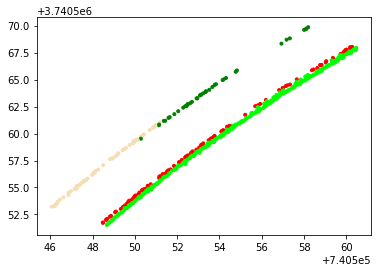

4


In [19]:
# REMOVE SMALL CLUSTERS

lines = {}

keep_clusters = []
histogram = {}

edges_for_cloud = []

for i in clustering.labels_:
    if i in histogram:
        histogram[i] += 1
    else:
        histogram[i] = 1

max_cluster = max(clustering.labels_)
average_cluster_size = statistics.mean([histogram[x] for x in histogram])
for i in range(max_cluster + 1):
    if histogram[i] >= average_cluster_size:
        keep_clusters.append(i)
        lines[i] = []

clustered_x = []
clustered_y = []
cluster_colors = []
for i in range(len(edges)):
    if clustering.labels_[i] in keep_clusters:
        clustered_x.append(edges[i][1].x)
        clustered_y.append(edges[i][1].y)
        cluster_colors.append(color_labels[clustering.labels_[i]])
        edges_for_cloud.append((edges[i][1].x, edges[i][1].y, edges[i][1].z))

        lines[clustering.labels_[i]].append(Point(edges[i][1]))

plt.scatter(clustered_x, clustered_y, marker='.', alpha=1, c=cluster_colors)
plt.show()

print(len(keep_clusters))


In [22]:
line_gradients = []
for id in keep_clusters:
    gradients = []
    for i in range(len(lines[id]) - 1):
        gradients.append(lines[id][i + 1].z - lines[id][i].z)
    line_gradients.append(gradients)
    print(len(gradients))

print(line_gradients)

303
95
39
52
[[-0.11440000000004602, 0.11600000000004229, -0.11150000000003502, 0.1149000000000342, -0.08199999999999363, 0.005599999999958527, -0.035499999999956344, 0.11479999999994561, -0.10759999999999081, 0.10450000000003001, -0.10890000000000555, 0.08150000000000546, -0.04009999999999536, 0.08409999999997808, -0.043099999999981264, 0.07630000000000337, -0.15100000000001046, 0.11849999999998317, 0.02400000000000091, -0.14440000000001874, 0.15610000000003765, -0.06929999999999836, 0.07450000000000045, -0.11760000000003856, 0.04650000000003729, -0.081799999999987, 0.1016999999999939, -0.061599999999998545, -0.03710000000000946, 0.11889999999999645, 0.023300000000006094, -0.06080000000002883, 0.08240000000000691, -0.16039999999998145, 0.12259999999997717, -0.11570000000000391, 0.009500000000002728, 0.03649999999998954, -0.024099999999975807, 0.06220000000001846, -0.07150000000001455, 0.032399999999995543, 0.0006999999999948159, 0.0010000000000331966, 0.04599999999999227, -0.077800000

In [15]:
edges_df = pd.DataFrame(edges_for_cloud, columns=["X", "Y", "Z"])
print(edges_df)

               X             Y         Z
0    740560.4623  3.740568e+06  261.0384
1    740560.2733  3.740568e+06  261.0671
2    740558.1960  3.740570e+06  261.1697
3    740560.4543  3.740568e+06  260.9240
4    740560.4118  3.740568e+06  261.0400
..           ...           ...       ...
488  740548.7135  3.740552e+06  261.5641
489  740548.4908  3.740552e+06  261.6828
490  740546.0758  3.740553e+06  261.8564
491  740548.6800  3.740552e+06  261.5710
492  740548.4908  3.740552e+06  261.6828

[493 rows x 3 columns]


In [ ]:
edges_df.to_csv("edges.csv")

In [ ]:
# # Renders The filtered points in 3D, and their retroflectivity

# filtered_xyz = offsetFilteredDf.filter(['X', 'Y', 'Z'])
# filtered_intensity = offsetFilteredDf.filter(['Retro'])

# filtered_intensity = np.array(filtered_intensity.Retro).transpose()
# print(filtered_intensity.shape)

# V = pptk.viewer(filtered_xyz)
# V.attributes(filtered_intensity)

In [ ]:
# Export to CSV

# offsetFilteredDf.to_csv("filtered_points.csv")